In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time

# --- MAC GPU SETUP ---
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
    print("🚀 SUCCESS: Using Apple MPS (Metal Performance Shaders) acceleration.")
elif torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print("Using NVIDIA CUDA acceleration.")
else:
    DEVICE = torch.device("cpu")
    print("⚠️ WARNING: Using CPU. Training will be slow.")

print(f"Active Device: {DEVICE}")
BATCH_SIZE = 64

🚀 SUCCESS: Using Apple MPS (Metal Performance Shaders) acceleration.
Active Device: mps


<h1>download dataset and load into model

In [20]:
def get_data_loaders(batch_size=64):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    
    # download=True will fetch it automatically to ./data
    print("Downloading/Loading dataset...")
    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    
    # Num_workers=0 is often safer/faster on Mac for small datasets like MNIST
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    return train_loader, test_loader

train_loader, test_loader = get_data_loaders(BATCH_SIZE)
print("✅ Data Loaders ready.")

Downloading/Loading dataset...


100%|██████████| 9.91M/9.91M [00:04<00:00, 2.26MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 87.2kB/s]
100%|██████████| 1.65M/1.65M [00:03<00:00, 491kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 1.72MB/s]

✅ Data Loaders ready.


<h1>activation functions

In [21]:
def get_activation(name):
    if name == 'relu': return nn.ReLU()
    elif name == 'sigmoid': return nn.Sigmoid()
    elif name == 'tanh': return nn.Tanh()
    else: raise ValueError(f"Unknown activation: {name}")

<h1>CNN architecture with 2 conv layers and 1 pooling and relu activation fxn

In [22]:
class BaseCNN(nn.Module):
    def __init__(self, activation_name='relu', dropout_rate=0.25):
        super(BaseCNN, self).__init__()
        self.activation_name = activation_name
        
        # Conv1: 32 filters, 3x3
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3) 
        # Conv2: 64 filters, 3x3
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        # Max Pool: 2x2
        self.pool = nn.MaxPool2d(kernel_size=2)
        # Dropout
        self.dropout = nn.Dropout(dropout_rate)
        
        # Flatten: 64 channels * 12 * 12 = 9216
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10) 

    def forward(self, x):
        act = get_activation(self.activation_name)
        x = act(self.conv1(x))
        x = act(self.conv2(x))
        x = self.pool(x)
        x = self.dropout(x)
        x = torch.flatten(x, 1)
        x = act(self.fc1(x))
        x = self.fc2(x) 
        return x

<h1>MLP architecture

In [23]:
class BaseMLP(nn.Module):
    def __init__(self, layer_sizes=[256, 128], use_bn=True, dropout_rate=0.0, activation_name='relu'):
        super(BaseMLP, self).__init__()
        self.layers = nn.ModuleList()
        input_dim = 784
        
        for size in layer_sizes:
            self.layers.append(nn.Linear(input_dim, size))
            if use_bn:
                self.layers.append(nn.BatchNorm1d(size))
            self.layers.append(get_activation(activation_name))
            if dropout_rate > 0:
                self.layers.append(nn.Dropout(dropout_rate))
            input_dim = size
            
        self.layers.append(nn.Linear(input_dim, 10))
    
    def forward(self, x):
        x = torch.flatten(x, 1)
        for layer in self.layers:
            x = layer(x)
        return x

In [24]:
def train_experiment(model, optimizer, train_loader, test_loader, epochs, name):
    print(f"\n--- Running: {name} ({epochs} epochs) ---")
    start_time = time.time()
    model.to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    
    history = {'train_loss': [], 'val_acc': []}
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        
        for data, target in train_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(DEVICE), target.to(DEVICE)
                output = model(data)
                _, predicted = torch.max(output.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
        
        avg_loss = running_loss / len(train_loader)
        val_acc = 100 * correct / total
        
        history['train_loss'].append(avg_loss)
        history['val_acc'].append(val_acc)
        
        print(f"  Ep {epoch+1}/{epochs} | Loss: {avg_loss:.4f} | Acc: {val_acc:.2f}%")
        
    duration = time.time() - start_time
    print(f"  ⏱️ Time: {duration:.1f}s")
    return history, val_acc

In [25]:
results_table = []
all_histories = {}
activations = ['sigmoid', 'tanh', 'relu']
best_activation = 'relu' 
best_acc = 0

print(">>> TASK 1: Activation Functions")
for act in activations:
    model = BaseCNN(activation_name=act)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # 5 epochs is enough to see the trend and save time
    hist, final_acc = train_experiment(model, optimizer, train_loader, test_loader, epochs=5, name=f"CNN_{act}")
    
    all_histories[f"CNN_{act}"] = hist
    results_table.append({"Task": "1.Act", "Config": act, "Acc": final_acc})
    
    if final_acc > best_acc:
        best_acc = final_acc
        best_activation = act

print(f"🏆 Winner Task 1: {best_activation}")

>>> TASK 1: Activation Functions

--- Running: CNN_sigmoid (5 epochs) ---
  Ep 1/5 | Loss: 0.5645 | Acc: 94.94%
  Ep 2/5 | Loss: 0.1288 | Acc: 97.63%
  Ep 3/5 | Loss: 0.0781 | Acc: 98.24%
  Ep 4/5 | Loss: 0.0554 | Acc: 98.39%
  Ep 5/5 | Loss: 0.0437 | Acc: 98.77%
  ⏱️ Time: 83.5s

--- Running: CNN_tanh (5 epochs) ---
  Ep 1/5 | Loss: 0.1450 | Acc: 97.50%
  Ep 2/5 | Loss: 0.0603 | Acc: 98.12%
  Ep 3/5 | Loss: 0.0492 | Acc: 98.24%
  Ep 4/5 | Loss: 0.0477 | Acc: 98.42%
  Ep 5/5 | Loss: 0.0426 | Acc: 98.26%
  ⏱️ Time: 79.5s

--- Running: CNN_relu (5 epochs) ---
  Ep 1/5 | Loss: 0.1222 | Acc: 97.87%
  Ep 2/5 | Loss: 0.0403 | Acc: 98.37%
  Ep 3/5 | Loss: 0.0269 | Acc: 99.07%
  Ep 4/5 | Loss: 0.0192 | Acc: 98.93%
  Ep 5/5 | Loss: 0.0140 | Acc: 99.02%
  ⏱️ Time: 78.6s
🏆 Winner Task 1: relu


In [26]:
optimizers_config = [
    ('SGD', lambda params: optim.SGD(params, lr=0.01)),
    ('SGD_Mom', lambda params: optim.SGD(params, lr=0.01, momentum=0.9)),
    ('Adam', lambda params: optim.Adam(params, lr=0.001))
]

print(">>> TASK 2: Optimizers")
for opt_name, opt_func in optimizers_config:
    model = BaseCNN(activation_name=best_activation)
    optimizer = opt_func(model.parameters())
    
    hist, final_acc = train_experiment(model, optimizer, train_loader, test_loader, epochs=5, name=f"CNN_{opt_name}")
    
    all_histories[f"CNN_{opt_name}"] = hist
    results_table.append({"Task": "2.Opt", "Config": f"{best_activation}+{opt_name}", "Acc": final_acc})

>>> TASK 2: Optimizers

--- Running: CNN_SGD (5 epochs) ---
  Ep 1/5 | Loss: 0.4206 | Acc: 93.29%
  Ep 2/5 | Loss: 0.1815 | Acc: 95.70%
  Ep 3/5 | Loss: 0.1308 | Acc: 96.49%
  Ep 4/5 | Loss: 0.1042 | Acc: 96.94%
  Ep 5/5 | Loss: 0.0861 | Acc: 97.68%
  ⏱️ Time: 76.2s

--- Running: CNN_SGD_Mom (5 epochs) ---
  Ep 1/5 | Loss: 0.1826 | Acc: 98.38%
  Ep 2/5 | Loss: 0.0506 | Acc: 98.75%
  Ep 3/5 | Loss: 0.0325 | Acc: 98.91%
  Ep 4/5 | Loss: 0.0246 | Acc: 98.92%
  Ep 5/5 | Loss: 0.0184 | Acc: 98.99%
  ⏱️ Time: 73.6s

--- Running: CNN_Adam (5 epochs) ---
  Ep 1/5 | Loss: 0.1172 | Acc: 98.43%
  Ep 2/5 | Loss: 0.0409 | Acc: 98.83%
  Ep 3/5 | Loss: 0.0258 | Acc: 98.96%
  Ep 4/5 | Loss: 0.0186 | Acc: 98.60%
  Ep 5/5 | Loss: 0.0139 | Acc: 98.86%
  ⏱️ Time: 78.4s


In [27]:
mlp_scenarios = [
    ("NoBN_NoDrop", False, 0.0),
    ("NoBN_Drop0.1", False, 0.1),
    ("WithBN_Drop0.25", True, 0.25)
]

print(">>> TASK 3: Normalization & Dropout")
for name, use_bn, drop_rate in mlp_scenarios:
    model = BaseMLP(layer_sizes=[256, 128], use_bn=use_bn, dropout_rate=drop_rate)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    hist, final_acc = train_experiment(model, optimizer, train_loader, test_loader, epochs=10, name=f"MLP_{name}")
    
    all_histories[f"MLP_{name}"] = hist
    results_table.append({"Task": "3.MLP", "Config": name, "Acc": final_acc})

>>> TASK 3: Normalization & Dropout

--- Running: MLP_NoBN_NoDrop (10 epochs) ---
  Ep 1/10 | Loss: 0.2256 | Acc: 96.25%
  Ep 2/10 | Loss: 0.0914 | Acc: 97.26%
  Ep 3/10 | Loss: 0.0631 | Acc: 97.02%
  Ep 4/10 | Loss: 0.0480 | Acc: 96.56%
  Ep 5/10 | Loss: 0.0392 | Acc: 97.81%
  Ep 6/10 | Loss: 0.0339 | Acc: 97.91%
  Ep 7/10 | Loss: 0.0277 | Acc: 98.06%
  Ep 8/10 | Loss: 0.0245 | Acc: 97.72%
  Ep 9/10 | Loss: 0.0195 | Acc: 97.76%
  Ep 10/10 | Loss: 0.0199 | Acc: 98.01%
  ⏱️ Time: 74.6s

--- Running: MLP_NoBN_Drop0.1 (10 epochs) ---
  Ep 1/10 | Loss: 0.2518 | Acc: 96.21%
  Ep 2/10 | Loss: 0.1095 | Acc: 97.16%
  Ep 3/10 | Loss: 0.0810 | Acc: 97.61%
  Ep 4/10 | Loss: 0.0657 | Acc: 97.75%
  Ep 5/10 | Loss: 0.0567 | Acc: 97.59%
  Ep 6/10 | Loss: 0.0473 | Acc: 97.72%
  Ep 7/10 | Loss: 0.0448 | Acc: 98.13%
  Ep 8/10 | Loss: 0.0387 | Acc: 98.05%
  Ep 9/10 | Loss: 0.0339 | Acc: 98.12%
  Ep 10/10 | Loss: 0.0355 | Acc: 97.93%
  ⏱️ Time: 77.7s

--- Running: MLP_WithBN_Drop0.25 (10 epochs) ---
  Ep 

In [28]:
# CNN-1: 10 Epochs
print(">>> SPECIFIC: CNN-1 (10 Epochs)")
model = BaseCNN(activation_name='relu', dropout_rate=0.25) # Standard config
optimizer = optim.Adam(model.parameters(), lr=0.001)
hist, final_acc = train_experiment(model, optimizer, train_loader, test_loader, epochs=10, name="CNN-1")
results_table.append({"Task": "PDF", "Config": "CNN-1 (Adam, 10ep)", "Acc": final_acc})

# MLP-1: 20 Epochs
print(">>> SPECIFIC: MLP-1 (20 Epochs)")
model = BaseMLP(layer_sizes=[512, 256, 128], use_bn=True, dropout_rate=0.25) 
optimizer = optim.SGD(model.parameters(), lr=0.01)
hist, final_acc = train_experiment(model, optimizer, train_loader, test_loader, epochs=20, name="MLP-1")
results_table.append({"Task": "PDF", "Config": "MLP-1 (SGD, 20ep)", "Acc": final_acc})

# MLP-2: 15 Epochs
print(">>> SPECIFIC: MLP-2 (15 Epochs)")
model = BaseMLP(layer_sizes=[256], use_bn=True, dropout_rate=0.25)
optimizer = optim.Adam(model.parameters(), lr=0.001)
hist, final_acc = train_experiment(model, optimizer, train_loader, test_loader, epochs=15, name="MLP-2")
results_table.append({"Task": "PDF", "Config": "MLP-2 (Adam, 15ep)", "Acc": final_acc})

>>> SPECIFIC: CNN-1 (10 Epochs)

--- Running: CNN-1 (10 epochs) ---
  Ep 1/10 | Loss: 0.1235 | Acc: 98.17%
  Ep 2/10 | Loss: 0.0410 | Acc: 98.85%
  Ep 3/10 | Loss: 0.0269 | Acc: 98.68%
  Ep 4/10 | Loss: 0.0195 | Acc: 99.08%
  Ep 5/10 | Loss: 0.0151 | Acc: 98.92%
  Ep 6/10 | Loss: 0.0118 | Acc: 99.00%
  Ep 7/10 | Loss: 0.0121 | Acc: 98.86%
  Ep 8/10 | Loss: 0.0091 | Acc: 99.05%
  Ep 9/10 | Loss: 0.0104 | Acc: 99.10%
  Ep 10/10 | Loss: 0.0058 | Acc: 99.02%
  ⏱️ Time: 158.0s
>>> SPECIFIC: MLP-1 (20 Epochs)

--- Running: MLP-1 (20 epochs) ---
  Ep 1/20 | Loss: 0.6305 | Acc: 94.45%
  Ep 2/20 | Loss: 0.2670 | Acc: 95.88%
  Ep 3/20 | Loss: 0.2079 | Acc: 96.65%
  Ep 4/20 | Loss: 0.1776 | Acc: 97.13%
  Ep 5/20 | Loss: 0.1526 | Acc: 97.46%
  Ep 6/20 | Loss: 0.1362 | Acc: 97.71%
  Ep 7/20 | Loss: 0.1222 | Acc: 97.74%
  Ep 8/20 | Loss: 0.1136 | Acc: 97.82%
  Ep 9/20 | Loss: 0.1038 | Acc: 98.05%
  Ep 10/20 | Loss: 0.0978 | Acc: 98.13%
  Ep 11/20 | Loss: 0.0893 | Acc: 98.14%
  Ep 12/20 | Loss: 0.086


=== FINAL RESULTS ===


,Task,Config,Acc
0,1.Act,sigmoid,98.77
1,1.Act,tanh,98.26
2,1.Act,relu,99.02
3,2.Opt,relu+SGD,97.68
4,2.Opt,relu+SGD_Mom,98.99
5,2.Opt,relu+Adam,98.86
6,3.MLP,NoBN_NoDrop,98.01
7,3.MLP,NoBN_Drop0.1,97.93
8,3.MLP,WithBN_Drop0.25,98.30
9,PDF,"CNN-1 (Adam, 10ep)",99.02


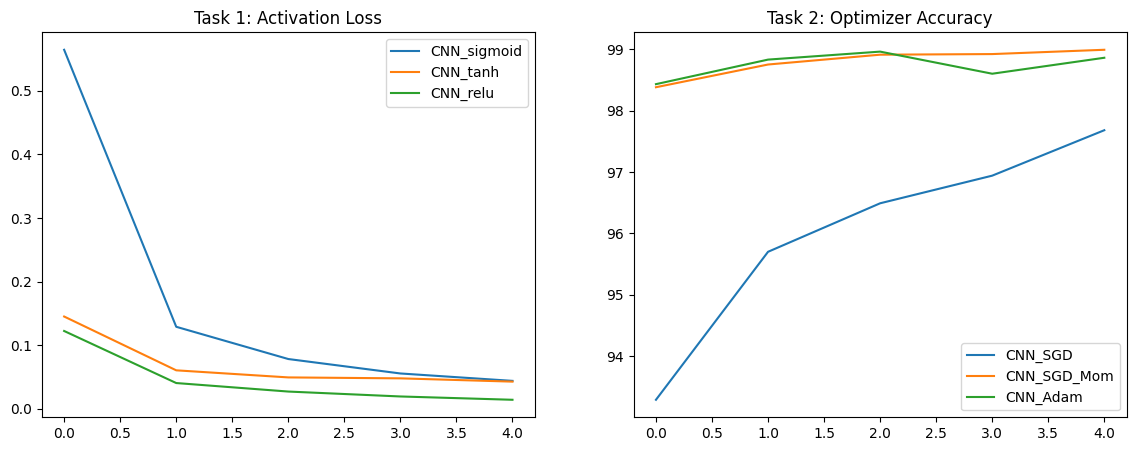

In [29]:
df = pd.DataFrame(results_table)
print("\n=== FINAL RESULTS ===")
display(df)

plt.figure(figsize=(14, 5))
# Plot Loss for Task 1
plt.subplot(1, 2, 1)
for k, v in all_histories.items():
    if "CNN_" in k and k.split("_")[1] in activations:
        plt.plot(v['train_loss'], label=k)
plt.title("Task 1: Activation Loss")
plt.legend()

# Plot Accuracy for Task 2
plt.subplot(1, 2, 2)
for k, v in all_histories.items():
    if "SGD" in k or "Adam" in k:
        # Filter to only show optimizers from Task 2 (CNN)
        if "CNN" in k and "sigmoid" not in k and "tanh" not in k: 
             plt.plot(v['val_acc'], label=k)
plt.title("Task 2: Optimizer Accuracy")
plt.legend()
plt.show()

### Final Assignment Results

| Experiment | Model Architecture | Activation | Optimizer | Regularization | Epochs | Test Accuracy (%) |
| :--- | :--- | :--- | :--- | :--- | :--- | :--- |
| **Task 1** | Base CNN | Sigmoid | Adam | Dropout (0.25) | 5 | **98.77%** |
| **Task 1** | Base CNN | Tanh | Adam | Dropout (0.25) | 5 | **98.26%** |
| **Task 1** | Base CNN | ReLU | Adam | Dropout (0.25) | 5 | **99.02%** |
| **Task 2** | Base CNN | ReLU | SGD | Dropout (0.25) | 5 | **97.68%** |
| **Task 2** | Base CNN | ReLU | SGD + Mom | Dropout (0.25) | 5 | **98.99%** |
| **Task 2** | Base CNN | ReLU | Adam | Dropout (0.25) | 5 | **98.86%** |
| **Task 3** | Base MLP | ReLU | Adam | None | 10 | **98.01%** |
| **Task 3** | Base MLP | ReLU | Adam | Dropout (0.1) | 10 | **97.93%** |
| **Task 3** | Base MLP | ReLU | Adam | BN + Dropout (0.25) | 10 | **98.30%** |
| **PDF Config** | CNN-1 | ReLU | Adam | Dropout (0.25) | 10 | **99.02%** |
| **PDF Config** | MLP-1 (512-256-128) | ReLU | SGD | BN + Dropout (0.25) | 20 | **98.33%** |
| **PDF Config** | MLP-2 (256) | ReLU | Adam | BN + Dropout (0.25) | 15 | **98.18%** |